**Reconocimiento de Neumonía con imágenes de radiografias**

***Grupo 04***

***Andrés Viñé Sánchez, Beatriz Aedo Díaz, Candela Esquinas Sánchez, José Antonio Ruiz Heredia***

## 1. Importación de librerías y cargar datos

In [546]:
# TensorFlow 
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Otros
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import cv2
import seaborn as sns
from Data_Paths import *
from keras.applications.resnet50 import ResNet50

Parámetros de preprocesado

In [547]:
blur = 1
contraste = 2.5
grid = 8
umbral = 120
noise_level = 0.2

### 1.1. Image Data Generators

In [548]:
# Función umbral
def threshold_image(image):
  _, threshold_image = cv2.threshold(image, umbral, 255, cv2.THRESH_BINARY)  
  return threshold_image


# Función PreProcesado
def preprocess_image(img):
    img = cv2.medianBlur(img, blur)
    
    return img


# Función PreProcesado con umbral
def preprocess_image_threshold(img):
    img = cv2.medianBlur(img, blur) 
    
    img = threshold_image(img)
    
    return img


# Función DataAugmentation
def custom_augmentation(img):
    # Preprocesado
    img = preprocess_image(img)

    # Ajustar el nivel de ruido gaussiano
    img = img.astype(np.float32)  # Convertir la imagen a tipo de datos de punto flotante
    img = cv2.addWeighted(img, 1 - noise_level, noise_level * np.random.randn(*img.shape).astype(np.float32), 0, 0)

    return img



In [549]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest',
  preprocessing_function=preprocess_image
)

test_datagen = ImageDataGenerator(
  rescale=1./255, 
)

val_datagen = ImageDataGenerator(
  rescale=1./255,
)


In [550]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATASET,
    target_size = (220, 220),
    batch_size = 16,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        TEST_DATASET,
        target_size = (220, 220),
        batch_size = 8,
        class_mode = 'binary'
)
test_generator = test_datagen.flow_from_directory(
    VAL_DATASET,
    shuffle = False,
    target_size = (220, 220),
    batch_size = 32,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## 2. Entrenamos el modelo

### 2.1. ResNet50V2

In [551]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import ResNet50V2

In [552]:
input_shape = (220, 220, 3)

# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
# Añadimos nuevas capas
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model and new layers into a single model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

In [553]:
# model.summary()

In [554]:
CHECKPOINT_PATH = os.path.join(MODEL_DATASET, 'pneumonia_classification_model_checkpoint.weights.h5')

# Create checkpoint callback.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                      save_weights_only = True,
                                      monitor = "val_accuracy",
                                      save_best_only = True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs.
# If val loss decreases for 5 epochs, stop training.
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                            mode = "min",
                                            patience = 5, 
                                            restore_best_weights = True)

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = len(train_generator)//16,
                    epochs = 50,
                    callbacks=[checkpoint_callback, callback])

Epoch 1/50


c:\src\Personal\SI\Chest_X_Ray_Pneumonia_Detection\sistemas_inteligentes\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.7378 - loss: 0.5836 - val_accuracy: 0.8269 - val_loss: 0.3720
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8971 - loss: 0.2915 - val_accuracy: 0.8237 - val_loss: 0.3745
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8886 - loss: 0.2407 - val_accuracy: 0.8494 - val_loss: 0.3559
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9101 - loss: 0.2279 - val_accuracy: 0.8750 - val_loss: 0.2999
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9492 - loss: 0.1674 - val_accuracy: 0.8894 - val_loss: 0.2891
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9309 - loss: 0.1837 - val_accuracy: 0.8974 - val_loss: 0.2967
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.9245 - loss: 0.2206 - val_accuracy: 0.8510 - val_loss: 0.3443
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9416 - loss: 0.1730 - val_accuracy: 0.7804 - val_loss: 0.5394
Epo

Save the model

In [555]:
MODEL_DATAPATH = os.path.join(MODEL_DATASET, 'pneumonia_classification_model_blur.h5')

# Save the entire model
model.save(MODEL_DATAPATH, overwrite=True)

Load the model

In [556]:

loaded_model = load_model(MODEL_DATAPATH)

### 3. Model metrics

In [557]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

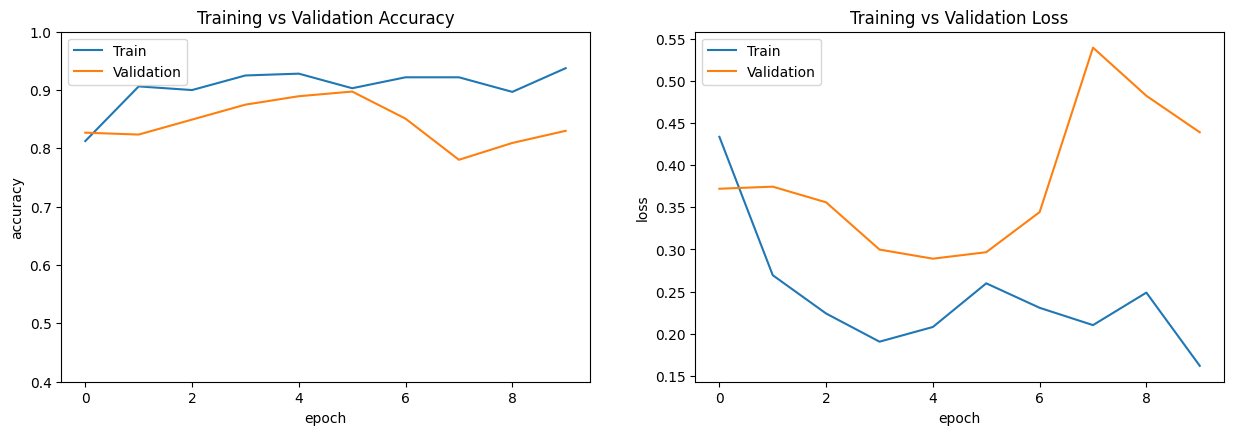

In [558]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

## 4. Predictions

In [559]:
# Make predictions for the test data.
pred = loaded_model.predict(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [560]:
pred

array([[0.11026464],
       [0.00270304],
       [0.0043699 ],
       [0.06133347],
       [0.04912634],
       [0.6927109 ],
       [0.00365426],
       [0.08417165],
       [0.99986637],
       [0.9958037 ],
       [0.66632116],
       [0.7904212 ],
       [0.20947535],
       [0.99766517],
       [0.9967597 ],
       [0.99225783]], dtype=float32)

In [561]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

y_pred

[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]

In [562]:
# Take the true information of the test data.
y_true = test_generator.classes

y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [563]:
cm = confusion_matrix(y_true, y_pred)

Text(50.72222222222221, 0.5, 'Truth')

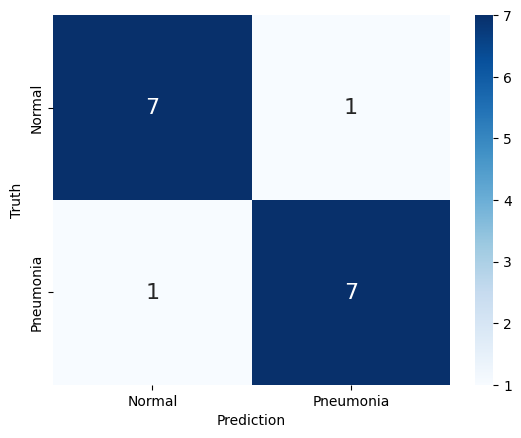

In [564]:
# Define the class names.
class_names = ['Normal', 'Pneumonia']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

In [565]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.88      0.88      0.88         8

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16



In [566]:
# Classify the test data cases into true negative, true positive, false positive,
# and false negative cases.
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [567]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,TN
1,TN
2,TN
3,TN
4,TN
5,FP
6,TN
7,TN
8,TP
9,TP


In [568]:
# Create a table with prediction, truth, and results.
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,0,0,TN
1,0,0,TN
2,0,0,TN
3,0,0,TN
4,0,0,TN
5,1,0,FP
6,0,0,TN
7,0,0,TN
8,1,1,TP
9,1,1,TP


In [569]:
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
5,1,0,FP


In [570]:
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results
12,0,1,FN


In [571]:
normal_test_images = glob.glob(VAL_DATASET + "/NORMAL/*.jpeg")
pneumonia_test_images = glob.glob(VAL_DATASET + "/PNEUMONIA/*.jpeg")

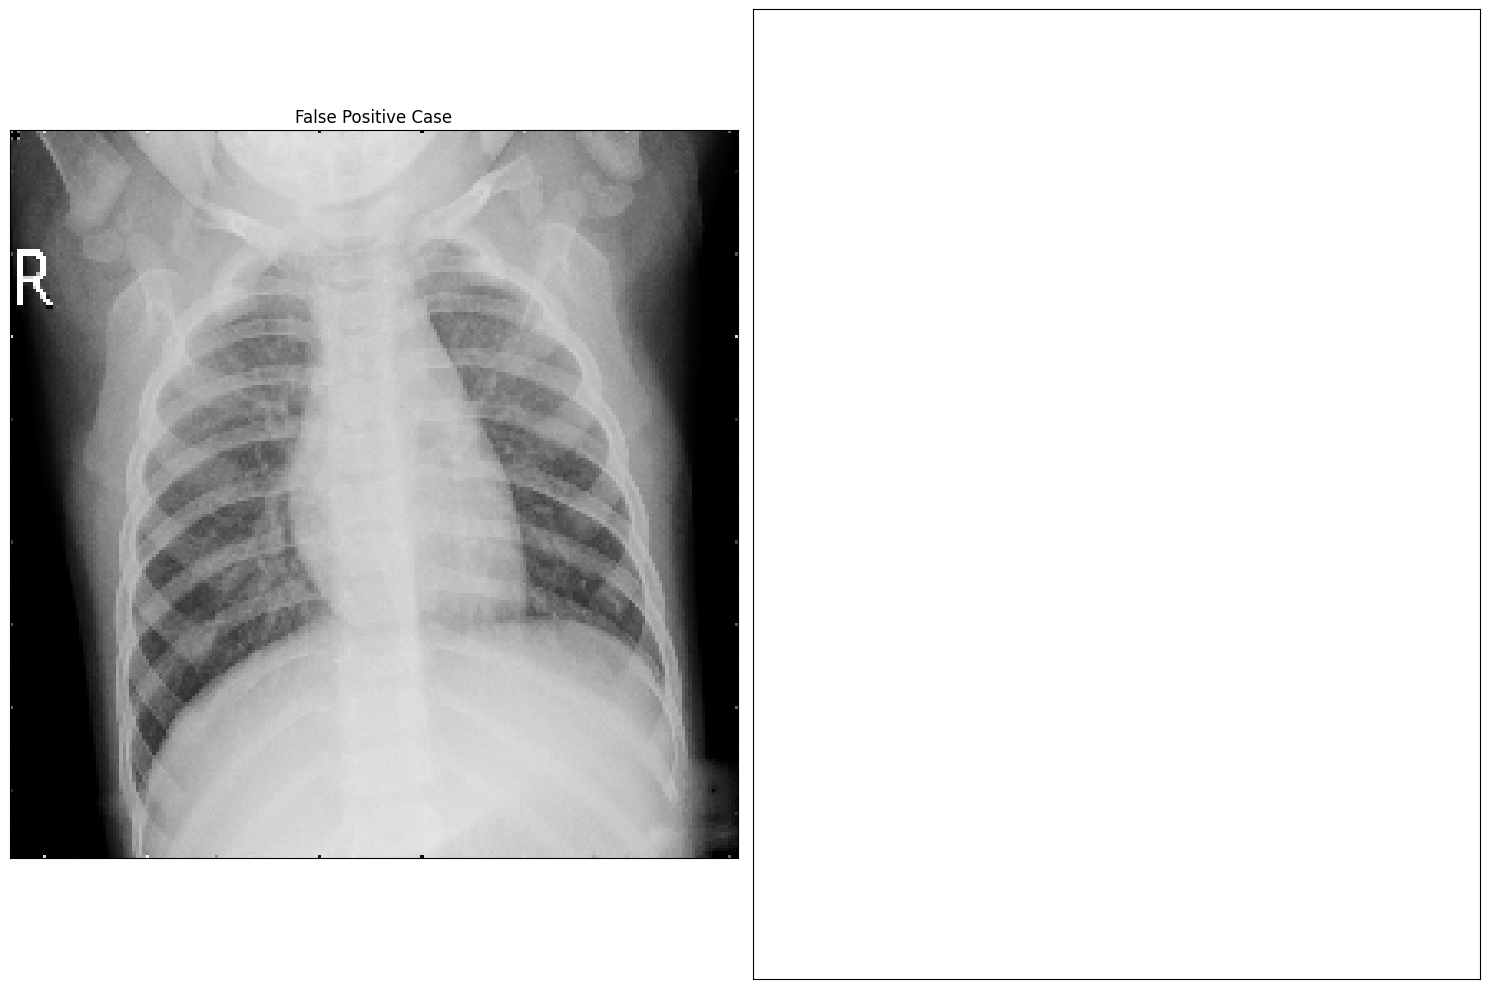

In [572]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# Visualize the false positive case(s) in the test data.
for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(normal_test_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()

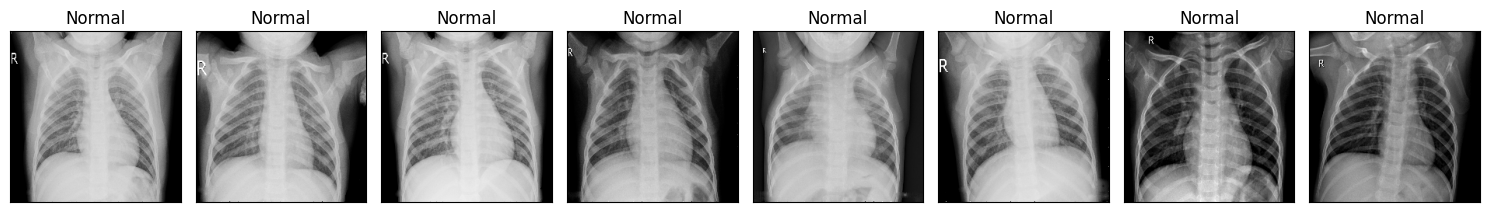

In [573]:
fig, axes = plt.subplots(nrows = 1, ncols = 8, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# Visualize the test data for comparison.
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_test_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    

plt.show()